In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import datetime
from bson import ObjectId
from pymongo import MongoClient
from scipy.optimize import minimize

In [2]:
client = MongoClient('127.0.0.1', 27017)
db = client.moniter_crowdfunding
# db.authenticate(name="craw", password="craw")

In [3]:
db.list_collection_names()

['system.views',
 'sucess_projects',
 'front_page',
 'projects',
 'founders',
 'failure_projects',
 'viewCateSucc',
 'viewCateFail']

In [4]:
project = db.projects
s_project = db.sucess_projects
f_project = db.failure_projects
front_page = db.front_page

- array查询

In [36]:
s_project.find_one({"项目动态信息.0.爬取时间": {'$gte': datetime.datetime(2019, 1, 1), 
                                       '$lte': datetime.datetime(2019, 1, 30)}},
                   projection={"_id":1, 
                               "项目名称": 1, 
                               "项目动态信息.爬取时间": 1,
                               "项目动态信息.支持者数": 1,
                               "项目动态信息": {"$slice": [10, 5]}})

{'_id': '104000',
 '项目动态信息': [{'爬取时间': datetime.datetime(2019, 1, 19, 0, 0, 14, 320000),
   '支持者数': 0},
  {'爬取时间': datetime.datetime(2019, 1, 19, 12, 0, 12, 630000), '支持者数': 0},
  {'爬取时间': datetime.datetime(2019, 1, 19, 18, 0, 14, 129000), '支持者数': 0},
  {'爬取时间': datetime.datetime(2019, 1, 20, 0, 0, 14, 78000), '支持者数': 0},
  {'爬取时间': datetime.datetime(2019, 1, 20, 6, 0, 14, 352000), '支持者数': 0}],
 '项目名称': '东方美学茶礼.边缘海干泡茶盘'}

In [33]:
s_project.find_one({"项目动态信息": {'$elemMatch': { '爬取时间': {'$gte': datetime.datetime(2019, 1, 1), 
                                       '$lte': datetime.datetime(2019, 1, 30)}}
                              }},
                   projection={"_id":1, "项目名称": 1, "项目动态信息.$": 1})

{'_id': '102720',
 '项目动态信息': [{'爬取时间': datetime.datetime(2019, 1, 1, 0, 5, 36, 555000),
   '筹集金额': 4564,
   '完成百分比': 91.0,
   '支持者数': 12,
   '点赞数': 1,
   '关注数': 31,
   '创建时间': datetime.datetime(2018, 12, 19, 13, 55, 20),
   '更新时间': datetime.datetime(2018, 12, 31, 13, 55, 19)}],
 '项目名称': '新年茶礼 釉下五彩茶具首发'}

In [29]:
s_project.find_one({"项目动态信息.爬取时间": {'$gte': datetime.datetime(2019, 1, 1), 
                                       '$lte': datetime.datetime(2019, 1, 30)}
                                          },
                   projection={"_id":1, "项目名称": 1, "项目动态信息.$": 1})

{'_id': '102720',
 '项目动态信息': [{'爬取时间': datetime.datetime(2019, 1, 1, 0, 5, 36, 555000),
   '筹集金额': 4564,
   '完成百分比': 91.0,
   '支持者数': 12,
   '点赞数': 1,
   '关注数': 31,
   '创建时间': datetime.datetime(2018, 12, 19, 13, 55, 20),
   '更新时间': datetime.datetime(2018, 12, 31, 13, 55, 19)}],
 '项目名称': '新年茶礼 釉下五彩茶具首发'}

In [5]:
num_Psucc = s_project.count_documents({'状态': '项目成功'})
num_Csucc = project.count_documents({'状态': '众筹成功'})
num_Cing = project.count_documents({'状态': '众筹中'})
num_Pheat = project.count_documents({'状态': '预热中'})
num_Fproj = f_project.count_documents({})
print(f'项目成功:{num_Psucc}', f'众筹成功:{num_Csucc}', 
      f'众筹中:{num_Cing}', f'预热中:{num_Pheat}', f'项目失败:{num_Fproj}', sep='\t')

项目成功:2987	众筹成功:162	众筹中:744	预热中:24	项目失败:1850


# 一、获取众筹项目扩散指标时间序列

- 1. 将原始数据库中的`item`转化为`df`数据格式

In [6]:
def to_df(item, col_names = ['星期', '关注数', '支持者数', '点赞数', '完成百分比', '筹集金额']):
    dyn_info = item['项目动态信息']
    t_fund = item['目标金额']
    
    # 剔除更新时间相同的记录
    a1 = dyn_info[0]
    records = {'更新时间':[], '星期':[], '支持者数':[], '关注数':[], '点赞数':[], '完成百分比':[], '筹集金额':[]}
    for i, a2 in enumerate(dyn_info):
        if a2["更新时间"] != a1['更新时间']:
            records['更新时间'].append(a2['更新时间'])
            records['星期'].append(a2['更新时间'].weekday())  # 0 -> monday, 1 -> tuesday, ..., y -> sunday
            records['支持者数'].append(a2['支持者数'])
            records['关注数'].append(a2['关注数'])
            records['完成百分比'].append(a2['完成百分比'])
            records['筹集金额'].append(a2['筹集金额'])
            records['点赞数'].append(a2['点赞数'])
            
            a1 = a2
            
    df = pd.DataFrame(records, index=records['更新时间'], columns=col_names)
    return df

- 2. 按每天最晚时间保留1个数据
> 对比相邻两个数据索引的时间(年-月-日)是否一致，从而获取是否是同一天的数据。

In [7]:
def retain_data(df):
    new_index = []
    for i, index in enumerate(df.index):
        if i == 0:
            a = df.index[i]
        else:
            b = df.index[i]
            a = df.index[i - 1]
            if (b.year, b.month, b.day) != (a.year, a.month, a.day):
                new_index.append(i-1)
    
    return df.iloc[new_index]

- 3. 保留众筹开始之后的数据，并将时间转换为相对众筹开始的绝对时长

In [8]:
def prepare_data(item):
    df = to_df(item)
    day_data = retain_data(df)
    data = day_data[day_data.index >= pd.Timestamp(item['状态变换时间1-2'])]  # 众筹开始后的数据
    
    interv_list = [t - pd.Timestamp(item['状态变换时间1-2']) for t in data.index]      
    t_list = list(map(lambda x : round(x.to_pytimedelta().total_seconds()/3600, 1), 
                      interv_list))  # 转换为相对众筹开始时间的绝对时长(小时)
    
    data.index = t_list
    return data

- 4. 非累积采纳数量

In [9]:
def increment(x):
    return [(x[i] - x[i-1]) if i >= 1 else x[0] 
            for i in range(len(x))]

# 二、获取众筹期间项目在主页各位置的展示时间

- 首先，获取时间序列`t_dict`。`t_dict`与`a_dict`键相对应，查看对应时期各监测时间点的各展区是否包含目标pid
> `get_demo_data`针对每个时间点的`front_page`进行处理

In [11]:
def get_demo_data(a_dict, t_dict, pid):
    for key in a_dict:
        if isinstance(a_dict[key], list):    
            if pid in a_dict[key]:
                t_dict[key] = t_dict.get(key, []) + [1]
            else:
                t_dict[key] = t_dict.get(key, []) + [0]
        elif isinstance(a_dict[key], dict):
            t_dict[key] = get_demo_data(a_dict[key], {}, pid)
        elif key == "监测时间":
            t_dict[key] = t_dict.get(key, []) + [a_dict[key]]
        else:
            pass
            
    return t_dict

- 然后，获取`t_dict`对应的`pd.DataFrame()`

In [12]:
def get_eff_data(t_dict, prev_keys=[], dataset={}):
    for key in t_dict:
        if isinstance(t_dict[key], list):
            c_key = '>'.join(prev_keys + [key]) if prev_keys else key
            dataset[c_key] = t_dict[key]
        else:
            dataset = get_eff_data(t_dict[key], prev_keys + [key], dataset)
    return dataset

- 最后，将主页展示时间数据与项目扩散数据融合

In [ ]:
def merge_df(item, )

- 示例

In [13]:
list(project.find({"状态变换时间0-1": {"$gt": datetime.datetime(2019, 9, 1)}, 
                   '状态': {'$in': ['众筹成功', '项目成功']}}, projection={"_id": True}))

[{'_id': '115609'},
 {'_id': '117186'},
 {'_id': '117399'},
 {'_id': '117511'},
 {'_id': '117643'},
 {'_id': '118161'},
 {'_id': '118764'},
 {'_id': '119081'},
 {'_id': '119189'},
 {'_id': '119240'},
 {'_id': '119359'},
 {'_id': '119417'},
 {'_id': '119446'},
 {'_id': '119597'},
 {'_id': '119608'},
 {'_id': '119629'},
 {'_id': '119909'},
 {'_id': '119961'},
 {'_id': '119962'},
 {'_id': '119997'},
 {'_id': '120000'},
 {'_id': '120017'},
 {'_id': '120030'},
 {'_id': '120049'},
 {'_id': '120057'},
 {'_id': '120080'},
 {'_id': '120087'},
 {'_id': '120101'},
 {'_id': '120102'},
 {'_id': '120104'},
 {'_id': '120112'},
 {'_id': '120123'},
 {'_id': '120127'},
 {'_id': '120132'},
 {'_id': '120145'},
 {'_id': '120149'},
 {'_id': '120169'},
 {'_id': '120191'},
 {'_id': '120194'},
 {'_id': '120202'},
 {'_id': '120203'},
 {'_id': '120215'},
 {'_id': '120228'},
 {'_id': '120239'},
 {'_id': '120244'},
 {'_id': '120256'},
 {'_id': '120258'},
 {'_id': '120270'},
 {'_id': '120271'},
 {'_id': '120274'},


In [13]:
p_df.head()

,星期,关注数,支持者数,点赞数,完成百分比,筹集金额
2019-10-11 00:01:22.532,4,1,0,0,0.0,0
2019-10-11 06:01:19.379,4,1,0,0,0.0,0
2019-10-11 12:02:20.089,4,1,0,0,0.0,0
2019-10-11 18:00:53.580,4,1,0,0,0.0,0
2019-10-12 00:01:19.852,5,1,0,0,0.0,0


In [16]:
front_df.iloc[0]

轮播>left                   0
轮播>r-t                    0
轮播>r-b-l                  0
轮播>r-b-r                  0
热门推荐                      0
最新上架                      0
即将结束                      0
demostr_proj>新奇酷玩>左上大图    0
demostr_proj>新奇酷玩>其它图     0
demostr_proj>健康出行>左上大图    0
demostr_proj>健康出行>其它图     0
demostr_proj>生活美学>左上大图    0
demostr_proj>生活美学>其它图     0
demostr_proj>美食市集>左上大图    0
demostr_proj>美食市集>其它图     0
demostr_proj>文化艺术>左上大图    0
demostr_proj>文化艺术>其它图     0
demostr_proj>惠民扶贫>左上大图    0
demostr_proj>惠民扶贫>其它图     0
即将上架                      1
Name: 2019-10-11 06:00:04.452000, dtype: int64

In [15]:
try:
    item = project.find_one({"_id": '121291'})  # 项目历史信息
    p_df = to_df(item)  # 转换扩散数据
    t_start, t_end = p_df.index[0], p_df.index[-1]  # 项目扩散数据最早与最晚时间点
    f_page = front_page.find({"监测时间": {"$gte":t_start, "$lte":t_end}},
                             sort=[('监测时间', 1)])  # 取出这个时间段的主页观察数据
    t_dict = {}  # 初始时刻无数据
    for a in f_page:
        t_dict = get_demo_data(a, t_dict, item["_id"])  # 迭代查看_id是否在各展区
    
    dataset = get_eff_data(t_dict)
    col_names = list(dataset)
    col_names.remove("监测时间")
    front_df = pd.DataFrame(dataset, index=dataset["监测时间"], columns=col_names)

    # eff_col_names = []  # 剔除全为False的列
    # sum_f_df = front_df.sum()
    # for x in sum_f_df.index:
    #     if sum_f_df[x] > 0:
    #         eff_col_names.append(x)

    # eff_front_df = front_df[eff_col_names]
    # clean_eff_front_df = eff_front_df[eff_front_df.sum(axis=1) > 0]  # 剔除全为False的时间点
except Exception as e:
    print(e)

In [25]:
clean_eff_front_df

,最新上架,即将结束,即将上架
2019-10-11 06:00:04.452,False,False,True
2019-10-11 12:00:04.946,False,False,True
2019-10-11 18:00:05.530,False,False,True
2019-10-12 00:00:04.011,False,False,True
2019-10-12 06:00:04.782,False,False,True
2019-10-12 12:00:04.855,False,False,True
2019-10-12 18:00:05.727,False,False,True
2019-10-13 12:00:05.662,True,False,False
2019-10-13 18:00:05.744,True,False,False
2019-10-14 00:00:04.999,True,False,False


In [45]:
a_dict = {}  # 初始化
for i, idx in enumerate(clean_eff_front_df.index):
    if i == 0:
        for col in eff_col_names:
            if clean_eff_front_df.loc[idx, col]:
                a_dict[col] = [6]
            else:
                a_dict[col] = [0]
    else:
        for col in eff_col_names:
            if clean_eff_front_df.loc[idx, col]:
                if a_dict[col][-1] == 0:
                    a_dict[col] = a_dict[col] + [6]
                else:
                    a_dict[col] = a_dict.get(col, []) + [round((clean_eff_front_df.index[i] - \
                                                      clean_eff_front_df.index[i-1]).
                                                     to_pytimedelta().total_seconds()\
                                                     /3600, 0)]
            else:
                a_dict[col] = a_dict.get(col, []) + [0]

a_dict_2 = {col: np.cumsum(a_dict[col]) for col in a_dict}
clean_df = pd.DataFrame(a_dict_2, index=clean_eff_front_df.index)

In [46]:
clean_df

,最新上架,即将结束,即将上架
2019-10-11 06:00:04.452,0.0,0.0,6.0
2019-10-11 12:00:04.946,0.0,0.0,12.0
2019-10-11 18:00:05.530,0.0,0.0,18.0
2019-10-12 00:00:04.011,0.0,0.0,24.0
2019-10-12 06:00:04.782,0.0,0.0,30.0
2019-10-12 12:00:04.855,0.0,0.0,36.0
2019-10-12 18:00:05.727,0.0,0.0,42.0
2019-10-13 12:00:05.662,6.0,0.0,42.0
2019-10-13 18:00:05.744,12.0,0.0,42.0
2019-10-14 00:00:04.999,18.0,0.0,42.0


In [32]:
b_dict = {}
for index in p_df.index:
    d = np.sum(index > clean_df.index)  # 当前项目扩散时间与主页呈现时间的比较
    for col in eff_col_names:
        if not d:
            b_dict[col] = b_dict.get(col, []) + [0]
        else:
            b_dict[col] = b_dict.get(col, []) + [clean_df.iloc[d-1][col]]
            
f_df = pd.DataFrame(b_dict, index=p_df.index)         

In [33]:
m_df = pd.concat([p_df, f_df], axis=1)
interv_list = [t - m_df.index[0] if i > 0 else pd.Timedelta(0, unit="hour") for i, t in enumerate(m_df.index)]      
t_list = list(map(lambda x : round(x.to_pytimedelta().total_seconds()/3600, 1), 
                  interv_list))  # 转换为相对众筹开始时间的绝对时长(小时)

m_df.index = t_list

In [34]:
m_df

,星期,关注数,支持者数,点赞数,完成百分比,筹集金额,最新上架,即将结束,即将上架
0.0,4,1,0,0,0.0,0,0.0,0.0,0.0
6.0,4,1,0,0,0.0,0,0.0,0.0,6.0
12.0,4,1,0,0,0.0,0,0.0,0.0,10.0
18.0,4,1,0,0,0.0,0,0.0,0.0,14.0
24.0,5,1,0,0,0.0,0,0.0,0.0,18.0
...,...,...,...,...,...,...,...,...,...
738.1,6,30,20,0,165.0,32957,16.0,24.0,30.0
744.2,0,30,20,0,165.0,32957,16.0,28.0,30.0
750.1,0,30,20,0,165.0,32957,16.0,32.0,30.0
756.1,0,30,20,0,165.0,32957,16.0,36.0,30.0


In [26]:
import matplotlib
myfont = matplotlib.font_manager.FontProperties(fname='/System/Library/Fonts/STHeiti Light.ttc')
mpl.rcParams['axes.unicode_minus'] = False

IndexError: tuple index out of range

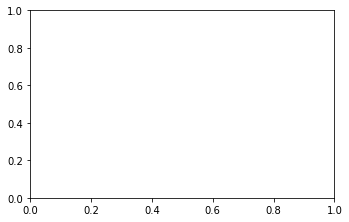

In [27]:
%matplotlib inline
fig = plt.figure(figsize=(12, 20))
for i, col in enumerate(m_df.columns, start=1):
    ax = fig.add_subplot(5, 2, i)
    ax.plot(m_df.index, m_df[col], label=col)
    ax.set_xlabel('时间', fontproperties=myfont, fontsize=12)
    ax.legend(prop=myfont)

fig.tight_layout()

## Bass

### 扩散分为两个阶段:
- 信息扩散
- 采纳行为扩散

In [ ]:
class estim_bass:
    def __init__(self, data):
        self.s = increment(data.支持者数.values)
        self.p_s = increment(data.完成百分比.values)
        self.t_list = data.index
        self.s_len= len(self.s)
        self.bounds = [(-0.5, 0.5), (-1, 1), (np.sum(self.s), 10 * np.sum(self.s))]
        self.ini_values = [0.05, 0.1,  1.5 * np.sum(self.s)]
    
    def non_cumm(self, x):
        return [(x[i] - x[i-1]) if i >= 1 else x[0] for i in range(len(x))]
    
    def bass(self, params):  # 如果要使用其它模型，可以重新定义
        p, q, m = params
        a = np.array([1 - np.exp(-(p + q) * t) for t in self.t_list])
        b = np.array([1 + q / p * np.exp(-(p + q) * t) for t in self.t_list])
        diffu_cont = m * a / b

#         adopt_cont = np.zeros_like(diffu_cont)  # 创建一个self.s_len长度的array
#         adopt_cont[0] = diffu_cont[0]  # 初始采纳数
#         for t in range(1, self.s_len):  # 非累积采纳数
#             adopt_cont[t] = diffu_cont[t] - diffu_cont[t - 1]
        adopt_cont = self.non_cumm(diffu_cont)
        return pd.Series(adopt_cont, index=self.t_list)
    
    def mse(self, params):  # 定义适应度函数（mse）
        a = self.bass(params)
        sse = np.sum(np.square(self.s - a))
        return np.sqrt(sse) / self.s_len  # 均方误

    def r2(self, params):  # 求R2
        f_act = self.bass(params)
        tse = np.sum(np.square(self.s - f_act))
        mean_y = np.mean(self.s)
        ssl = np.sum(np.square(self.s - mean_y))
        R_2 = (ssl - tse) / ssl
        return R_2
    
    def solve(self):
        try:
            sol = minimize(self.mse, self.ini_values, bounds=self.bounds, method='SLSQP')
            return {'mse': sol.fun, 'r2': self.r2(sol.x), 'p': sol.x[0], 'q': sol.x[1], 'm': int(sol.x[2])}
        except Exception as E:
            print("寻优失败")
            print(E)

### 对单条众筹成功项目的数据处理

In [ ]:
res_list = []
for i, item in enumerate(project.find({"状态": '项目成功'})):
    try:
        data = prepare_data(item)
#         s1 = increment(data.支持者数.values)
#         s2 = increment(data.完成百分比.values)
#         t_list = data.index
        
        eb = estim_bass(data)
        a = eb.solve()
        res_list.append([i, a])
    except Exception as e:
        print(i, e)

In [ ]:
for i, a in res_list:
    if a['r2'] > 0.8 and a['q'] > 0:
        print(f"{i}, {a['r2']:.4f}, {a['p']:.4f}, {a['q']:.4f}, {a['m']:.0f}")

In [ ]:
succ_projs = project.find({"状态": "项目成功"})
item = succ_projs[1977]

data = prepare_data(item)
# s1 = increment(data.支持者数.values)
# s2 = increment(data.完成百分比.values)
# t_list = data.index

eb = estim_bass(data)
a = eb.solve()
estimates = [a['p'], a['q'], a['m']]
print(a)
plt.scatter(t_list, s2, color="grey", alpha=0.3)
plt.plot(t_list, s2, lw=0.5, color="grey", linestyle="--")
plt.plot(t_list, eb.bass(estimates), 'r-', lw=2)

In [ ]:
eb.t_list = np.arange(1, 25)
x = eb.bass([0.005, 0.2, 200])
plt.plot(eb.t_list, x, 'ro--')

In [ ]:
len(x)

In [ ]:
def describe_plot(item):
    start_time = item['状态变换时间1-2']
    end_time = item['状态变换时间2-3']

    print(f"项目编号: {item['_id']}\n项目名称: {item['项目名称']}\n所属类别: {item['所属类别']}\n公司名称: {item['公司名称']}")
    print(f"\n众筹期限: {item['众筹期限']}天\n项目状态: {item['状态']}")
    print()
    print("发起人页面:", f"http://z.jd.com/project/details/{item['_id']}.html") 
    print("项目页面:", f"http://z.jd.com{item['发起人链接']}")
    print()
    print('预热中:', item['状态变换时间0-1'].strftime('%Y{y}%m{m}%d{d} %H:%M:%S').format(y='年',m='月',d='日'), sep='\t') 
    print('预热中->众筹中:', start_time.strftime('%Y{y}%m{m}%d{d} %H:%M:%S').format(y='年',m='月',d='日'), sep='\t')
    print('众筹中->众筹成功:', end_time.strftime('%Y{y}%m{m}%d{d} %H:%M:%S').format(y='年',m='月',d='日'), sep='\t')
    print('众筹中->项目成功:', item['状态变换时间3-4'].strftime('%Y{y}%m{m}%d{d} %H:%M:%S').format(y='年',m='月',d='日'), sep='\t')

    data = to_df(item)
    day_data = transfer_to_day(data)
    t_fund = day_data['筹集金额'][-1]
    print()
    print("众筹前的关注者数增长:")
    print(day_data[['关注数','点赞数']].loc[:start_time])

    fig = plt.figure(figsize=(12, 9))
    myfont = mpl.font_manager.FontProperties(fname="/Library/Fonts/Songti.ttc")
    mpl.rcParams['axes.unicode_minus'] = False
    for i, col in enumerate(col_names, start=1):
        ax = fig.add_subplot(3, 2, i)
        ax.plot(day_data.index, increment(day_data[col]), 'r-', lw=0.5)
        ax.scatter(day_data.index.values, increment(day_data[col].values), color='grey', alpha=0.5)
        ax.set_ylabel(col, fontproperties=myfont, fontsize=16)
        ax.set_xlim([day_data.index.values[0], day_data.index.values[-1]])
        ax.axvline(start_time, color='green', linestyle='--', linewidth=0.5)
        ax.axvline(end_time, color='red', linestyle='--', linewidth=0.5)
        for tick in ax.get_xticklabels():
            tick.set_rotation(30)

        if i == 4:
            ax.axhline(100, color='blue', linestyle='--', linewidth=0.5)

        if i == 5:
            ax.axhline(t_fund, color='blue', linestyle='--', linewidth=0.5)
            ax.text(day_data.index.values[0], t_fund*0.8, f"{t_fund}元", fontproperties=myfont, fontsize=13, color='green')

    fig.tight_layout()
    return day_data

In [ ]:
item = succ_projs[174]
day_data = describe_plot(item)

- 累积扩散图

In [ ]:
fig = plt.figure(figsize=(12, 9))
myfont = mpl.font_manager.FontProperties(fname="/Library/Fonts/Songti.ttc")
mpl.rcParams['axes.unicode_minus'] = False
for i, col in enumerate(col_names, start=1):
    ax = fig.add_subplot(3, 2, i)
    ax.plot(day_data.index, day_data[col], 'r-')
    ax.scatter(day_data.index.values, day_data[col].values, color='grey', alpha=0.5)
    ax.set_ylabel(col, fontproperties=myfont, fontsize=16)
    ax.set_xlim([day_data.index.values[0], day_data.index.values[-1]])
    ax.axvline(start_time, color='green', linestyle='--', linewidth=0.5)
    ax.axvline(end_time, color='red', linestyle='--', linewidth=0.5)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    if i == 4:
        ax.axhline(100, color='blue', linestyle='--', linewidth=0.5)
    
    if i == 5:
        ax.axhline(t_fund, color='blue', linestyle='--', linewidth=0.5)
        ax.text(day_data.index.values[0], t_fund*0.8, f"{t_fund}元", fontproperties=myfont, fontsize=13, color='blue')
        
fig.tight_layout()

- 评论数据处理：分别选取出众筹开始前后的评论

In [ ]:
review = x['评论']['评论详细']
list_review = sorted(review.items())

strpTime = datetime.datetime.strptime  # 日期字符串转换为datetime对象
before_items = [(strpTime(item[1]['创建时间'], "%Y-%m-%d %H:%M:%S"), item[1]['评论内容']) for item in list_review 
                if strpTime(item[1]['创建时间'], "%Y-%m-%d %H:%M:%S") <= start_time]
after_items = [(strpTime(item[1]['创建时间'], "%Y-%m-%d %H:%M:%S"), item[1]['评论内容']) for item in list_review 
               if strpTime(item[1]['创建时间'], "%Y-%m-%d %H:%M:%S") > start_time]

print(f'众筹开始前评论数量: {len(before_items)}\n众筹开始后评论数量: {len(after_items)}')

In [ ]:
for dt, item in after_items:
    print(dt.date(), item)

### 分析众筹成功项目

In [ ]:
succ_project = project.find({'状态': '项目成功'})

In [ ]:
print('预热中:', succ_project[1]['状态变换时间0-1'].strftime('%Y年%m月%d日 %H:%M:%S'), sep='\t') 
print('预热中->众筹中:', succ_project[1]['状态变换时间1-2'].strftime('%Y年%m月%d日 %H:%M:%S'), sep='\t')
print('众筹中->众筹成功:', succ_project[1]['状态变换时间2-3'].strftime('%Y年%m月%d日 %H:%M:%S'), sep='\t')
print('众筹中->项目成功:', succ_project[1]['状态变换时间3-4'].strftime('%Y年%m月%d日 %H:%M:%S'), sep='\t')

- 项目成功时间
> 查看从众筹开始到众筹成功的时间分布。

In [ ]:
def get_status():
    
    return

In [ ]:
x = project.find_one({}).keys()

In [ ]:
for d in sorted(list(x)):
    print(d)

In [ ]:
project.find_one({'状态': "项目成功"}, projection={"项目动态信息":0, "各档基础信息":0, "各档动态信息":0, "评论":0})

In [ ]:
def to_df(item):
    dyn_info = item['项目动态信息']
    t_fund = item['目标金额']
    start_t = item['状态变换时间1-2']  # 众筹开始时间
    end_t = item['状态变换时间2-3']  # 众筹成功时间

    # 去除重复
    a1 = dyn_info[0]
    records = {'更新时间':[], '支持者数':[], '关注数':[], '点赞数':[], '完成百分比':[], '筹集金额':[]}
    for i, a2 in enumerate(dyn_info):
        if a2["更新时间"] != a1['更新时间']:
            records['更新时间'].append(a2['更新时间'])
            records['支持者数'].append(a2['支持者数'])
            records['关注数'].append(a2['关注数'])
            records['完成百分比'].append(a2['完成百分比'])
            records['筹集金额'].append(a2['筹集金额'])
            records['点赞数'].append(a2['点赞数'])
            a1 = a2

    # 绘图
    col_names = ['关注数', '支持者数', '点赞数', '完成百分比', '筹集金额']
    df = pd.DataFrame(records, index=records['更新时间'], columns=col_names)
    return df

In [ ]:
def getTimeRange(df)
    x = df[df.index > start_t]
    y = x[x.完成百分比.values > 100]
    d = x[:y.index[0]]
    return d

In [151]:
from functools import partial

def f(x, y, z):
    return x + y + z

g = partial(f, z=10)
g(1,2)

13

In [158]:
g(x=1,y=2, z=3)

6

In [159]:
g

functools.partial(<function f at 0x1334a47b8>, z=10)